# Installation des librairies

In [ ]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
import re
import string
from nltk.tokenize import word_tokenize
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings
warnings.simplefilter(action='ignore')
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('words')
import spacy
nlp = spacy.load("en_core_web_sm")
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import pdist

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


# Lecture des données

In [ ]:
df0 = pd.read_csv("/content/anthems.csv", encoding='utf-8')
print(df0.info())
df0.head()

In [ ]:
df0.head()

,Country,Alpha-2,Alpha-3,Continent,Anthem
0,Albania,AL,ALB,Europe,"Around our flag we stand united, With one wish..."
1,Armenia,AM,ARM,Europe,"Our Fatherland, free, independent, That has fo..."
2,Austria,AT,AUT,Europe,"Land of mountains, land by the river, Land of ..."
3,Azerbaijan,AZ,AZE,Europe,"Azerbaijan, Azerbaijan! The glorious Fatherlan..."
4,Belarus,BY,BLR,Europe,"We, Belarusians, are peaceful people, Wholehea..."


Le fichier csv `anthems.csv` comporte une table de 190 lignes et 5 colonnes stockée en mémoire avec un poids de 7.5 KB. Il n'y a aucune valeur manquante et toutes les variables sont de type *string* ; ce sont toutes des variables qualitatives. 

**Dictionnaire de données :**
* **Country :** Nom complet du pays (*e.g.* Albania, France)
* **Alpha-2 :** Code ID du pays au format AA (*e.g.* Armenia pour AM, Belarus pour BY)
* **Alpha-3 :** Code ID du pays au format AAA (*e.g.* Armenia pour ARM, Belarus pour BLR)
* **Continent :** Nom complet du continent dans lequel se trouve le pays (*e.g.* France pour Europe, Canada pour Amérique)
* **Anthem :** Hymne nationale du pays 

# Création de la table de travail
Le stockage d'objet string est extrêmement coûteux en mémoire. Aussi, pour réaliser des analyses sur la variable `Anthem` uniquement nous décidons de créer deux tableaux. Le premier comportera les données de localisation et le second possédera la variable d'analyse. 

Lorsque nous réaliserons d'autres analyses, il sera utile de pouvoir récupérer les données de chaque tableau, il nous faut donc déterminer une clef ; pour cela nous avons besoin d'une variable comportant des données unique (*i.e.* sans doublon).

Au regard, de nos résultats, nous décidons de sélectionner la variable `Alpha-3`.

In [ ]:
df1 = df0.drop(["Country", "Alpha-2", "Alpha-3"], axis = 1)
tab_ref = df0.drop(["Anthem"], axis = 1)
df1

In [ ]:
print("Nom de colonnes de la table d'analyse : ", df1.columns)
print("Nom de colonnes de la table de référence : ", tab_ref.columns)

# Nettoyage de la variable *Anthem*

In [ ]:
stopwords = nltk.corpus.stopwords.words('english')
words = set(nltk.corpus.words.words())
lemmatizer = WordNetLemmatizer()

In [ ]:
import pandas as pd
import unicodedata

def clean_text(text):
    cleaned_text = []
    for t in text:
        t_cleaned = unicodedata.normalize('NFKD', str(t)).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        t_cleaned = ''.join([char for char in t_cleaned if char.isalpha() or char.isspace()])
        t_cleaned = t_cleaned.strip()
        cleaned_text.append(t_cleaned)
    return cleaned_text

In [ ]:
# Convertir la colonne en une liste de chaînes de caractères
anthems = df1['Anthem'].tolist()

# Appliquer la fonction clean_text() à chaque élément de la liste
cleaned_anthems = clean_text(anthems)

# Mettre à jour la colonne "Anthem" avec les valeurs nettoyées
df1['Anthem'] = cleaned_anthems


In [ ]:
df2 = df1.loc[df1['Anthem'].isin(cleaned_anthems)]
df2

In [ ]:
df2['Anthem'] = df2['Anthem'].str.replace('Aaa', '')
df2

In [ ]:
daata = 'Anthem.xlsx' 
df2.to_excel(daata) 
df2

In [ ]:
df1 = pd.read_excel("/content/Anthem.xlsx")
df1.drop('Unnamed: 0', axis=1, inplace=True)
df1

In [ ]:
def clean_data_text(df, col_name):
  
  for row in range(len(df)):
        
        df.loc[row, col_name] = "".join([i.lower() for i in df.loc[row, col_name] if i not in string.punctuation]) #supprime la ponctuation et majuscule -> minuscule
        df.loc[row, col_name] = re.sub(r'[0-9]', '', df.loc[row, col_name]) #supprime les chiffres
        df.loc[row, col_name] = re.sub(r'\W|_', ' ', df.loc[row, col_name]) #supprime les caractères non alphanumérique et underscore
        df.loc[row, col_name] = re.sub(r'\s+', ' ', df.loc[row, col_name]) #supprime les doubles espaces
        df.loc[row, col_name] = re.sub(r'^\s|\s$', '', df.loc[row, col_name]) #supprime les espaces au début et fin du texte
        df.loc[row, col_name] = re.sub(r'\s+[a-zA-Z]\s+', ' ', df.loc[row, col_name]) #supprime les lettres isolées
        df.loc[row, col_name] = re.sub(r'^b\s+', ' ', df.loc[row, col_name]) #supprime les b isolés en début de ligne
        #df.loc[row, col_name] = re.sub("\S*\d\S*"," ", df.loc[row, col_name])   # removes numbers and words concatenated with numbers IE h4ck3r. Removes road names such as BR-381.
        #df.loc[row, col_name] = re.sub("\S*@\S*\s?"," ", df.loc[row, col_name]) # removes emails and mentions (words with @)
        #df.loc[row, col_name] = re.sub(r'http\S+', '', df.loc[row, col_name])   # removes URLs with http
        #df.loc[row, col_name] = re.sub(r'www\S+', '', df.loc[row, col_name])    # removes URLs with www

        
        tokenize_phrase = nltk.tokenize.word_tokenize(df.loc[row, col_name]) #chaque caractère isolés par des espaces devient l'élément d'une liste
        df.loc[row, col_name] = [i for i in tokenize_phrase if i not in stopwords] #supprime les mots les plus courrants avec peu d'importance (ex:'our')

  return df 

In [ ]:
clean_data_text(df1, 'Anthem')


In [ ]:
df1

In [ ]:
print('Phrase de base : ', df0['Anthem'][0])
print("")
print('Phrase nettoyée : ', df1["Anthem"][0])

# Lemmatisation de la variable Anthem

In [ ]:
def lemmatize_df(df, col_name):
    
    df2 = df1.copy()
    df2[col_name] = df2[col_name].astype(str)
    df2[col_name] = df2[col_name].apply(lambda text: " ".join([token.lemma_ for token in nlp(text)]))
    
    return df2
df2    

In [ ]:
daata = 'Anthemnew.xlsx' 
df2.to_excel(daata) 
df2

In [ ]:
df2 = df2.copy()
df2 = lemmatize_df(df2, "Anthem")

print("Types associés aux mots de la première hymne :")
print("")
print(df2["Anthem"][0])

# Grammaire de la variable Anthem

In [ ]:
def type_mot(phrase):
    
    type_list = []
    
    for mot in phrase:
        doc = nlp(mot)
        type_list.append([(token, token.pos_) for token in doc])
    
    return type_list

df2_type = df2.copy()
df2_type = df2_type["Anthem"].apply(lambda x: type_mot(x))

print("Types associés aux mots de la première hymne :")
print("")
print(df2_type[0])

In [ ]:
df2_type = df2.copy()
df2_type = df2_type["Anthem"].apply(lambda x: type_mot(x))

print("Types associés aux mots de la première hymne :")
print("")
print(df2_type[0])

Types associés aux mots de la première hymne :

[[([, 'X')], [( , 'SPACE')], [(', 'PUNCT')], [( , 'SPACE')], [(a, 'PRON')], [(r, 'X')], [(o, 'X')], [(u, 'NOUN')], [(n, 'CCONJ')], [(d, 'X')], [( , 'SPACE')], [(', 'PUNCT')], [( , 'SPACE')], [(,, 'PUNCT')], [( , 'SPACE')], [(', 'PUNCT')], [( , 'SPACE')], [(f, 'X')], [(l, 'NOUN')], [(a, 'PRON')], [(g, 'PROPN')], [( , 'SPACE')], [(', 'PUNCT')], [( , 'SPACE')], [(,, 'PUNCT')], [( , 'SPACE')], [(', 'PUNCT')], [( , 'SPACE')], [(s, 'NOUN')], [(t, 'NOUN')], [(a, 'PRON')], [(n, 'CCONJ')], [(d, 'X')], [( , 'SPACE')], [(', 'PUNCT')], [( , 'SPACE')], [(,, 'PUNCT')], [( , 'SPACE')], [(', 'PUNCT')], [( , 'SPACE')], [(u, 'NOUN')], [(n, 'CCONJ')], [(i, 'PRON')], [(t, 'NOUN')], [(e, 'X')], [(d, 'X')], [( , 'SPACE')], [(', 'PUNCT')], [( , 'SPACE')], [(,, 'PUNCT')], [( , 'SPACE')], [(', 'PUNCT')], [( , 'SPACE')], [(o, 'X')], [(n, 'CCONJ')], [(e, 'X')], [( , 'SPACE')], [(', 'PUNCT')], [( , 'SPACE')], [(,, 'PUNCT')], [( , 'SPACE')], [(', 'PUNCT')], [( , 'SPA

# Vectorisation de la variable


Nous allons maintenant appliquer la fonction TF-IDF, fréquence de document inverse à court terme, qui est une statistique numérique destinée à refléter l’importance d’un mot pour un document dans un corpus en donnant à chaque mot d’un document une note allant de 0 à 1.

#Statistical Weighting of Words

Nous allons maintenant appliquer la fonction TF-IDF, fréquence de document inverse à court terme, qui est une statistique numérique destinée à refléter l’importance d’un mot pour un document dans un corpus en donnant à chaque mot d’un document une note allant de 0 à 1

Transpose le DataFrame final_df pour obtenir les termes en tant que colonnes. Ensuite, la méthode nlargest est utilisée pour sélectionner les 5 lignes ayant les valeurs les plus élevées dans la première colonne (correspondant au premier texte). Cela permet d'identifier les 5 termes les plus importants pour ce texte en fonction de leur poids TF-IDF.

In [ ]:
corpus = df2['Anthem'].tolist()
corpus[18][0:447]

In [ ]:
df2

In [ ]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
tf_idf = pd.DataFrame(data = X.toarray(), columns=vectorizer.get_feature_names_out())

final_df = tf_idf

print("{} rows".format(final_df.shape[0]))
final_df.T.nlargest(100, 0)

In [ ]:
# first 5 words with highest weight on document 0:
final_df.T.nlargest(5, 0)

#K-MEANS

Fonction qui exécute l’algorithme K-Means max_k fois et retourne un dictionnaire de chaque résultat k



In [ ]:
def run_KMeans(max_k, df):
    max_k += 1
    kmeans_results = dict()
    for k in range(2 , max_k):
        kmeans = cluster.KMeans(n_clusters = k
                               , init = 'k-means++'
                               , n_init = 10
                               , tol = 0.0001
                               , random_state = 1
                               , algorithm = 'full')

        kmeans_results.update( {k : kmeans.fit(df)} )
        
    return kmeans_results


# Silhouette Score de notre variable Anthem

Silhouette Score
 C'est une mesure de la similitude d’un objet avec son propre cluster (cohésion) par rapport à d’autres clusters (séparation).

In [ ]:
# K-Means
from sklearn import cluster
def printAvg(avg_dict):
    for avg in sorted(avg_dict.keys(), reverse=True):
        print("Avg: {}\tK:{}".format(avg.round(4), avg_dict[avg]))
        
def plotSilhouette(df, n_clusters, kmeans_labels, silhouette_avg):
    fig, ax1 = plt.subplots(1)
    fig.set_size_inches(8, 6)
    ax1.set_xlim([-0.2, 1])
    ax1.set_ylim([0, len(df) + (n_clusters + 1) * 20])
    
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--") # The vertical line for average silhouette score of all the values
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.title(("Silhouette analysis for K = %d" % n_clusters), fontsize=10, fontweight='bold')
    
    y_lower = 10
    sample_silhouette_values = silhouette_samples(df, kmeans_labels) # Compute the silhouette scores for each sample
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[kmeans_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i)) # Label the silhouette plots with their cluster numbers at the middle
        y_lower = y_upper + 10  # Compute the new y_lower for next plot. 10 for the 0 samples
    plt.show()
    
        
def silhouette(kmeans_dict, df, plot=False):
    df = df.to_numpy()
    avg_dict = dict()
    for n_clusters, kmeans in kmeans_dict.items():      
        kmeans_labels = kmeans.predict(df)
        silhouette_avg = silhouette_score(df, kmeans_labels) # Average Score for all Samples
        avg_dict.update( {silhouette_avg : n_clusters} )
    
        if(plot): plotSilhouette(df, n_clusters, kmeans_labels, silhouette_avg)
        
def get_silhouette_scores(data, max_k):
    scores = []
    
    for k in range(2, max_k+1):
        kmeans = KMeans(n_clusters=k, random_state=0).fit(data)
        score = silhouette_score(data, kmeans.labels_)
        scores.append(score)
    
    return scores        

In [ ]:
max_k = 100
df4_array = final_df.values
scores = get_silhouette_scores(df4_array, max_k)

plt.figure(figsize=(10,5))

plt.plot(range(2, max_k+1), scores)

plt.title("Silhouette du score de chaque k")
plt.xlabel("Nombre de clusters")
plt.ylabel("Silhouette du score")

plt.show()

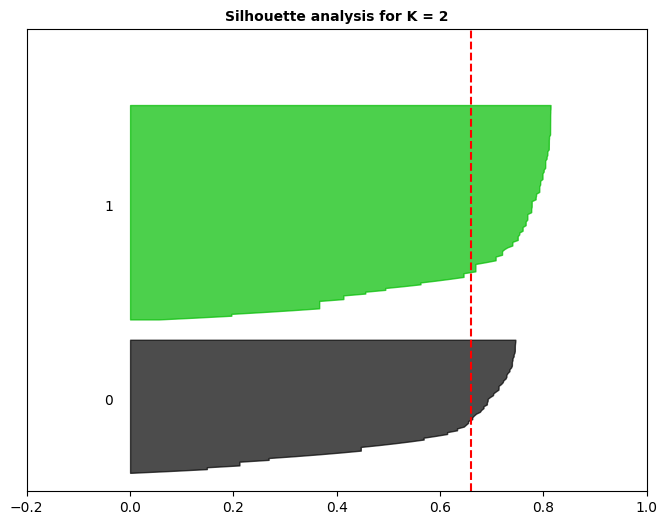

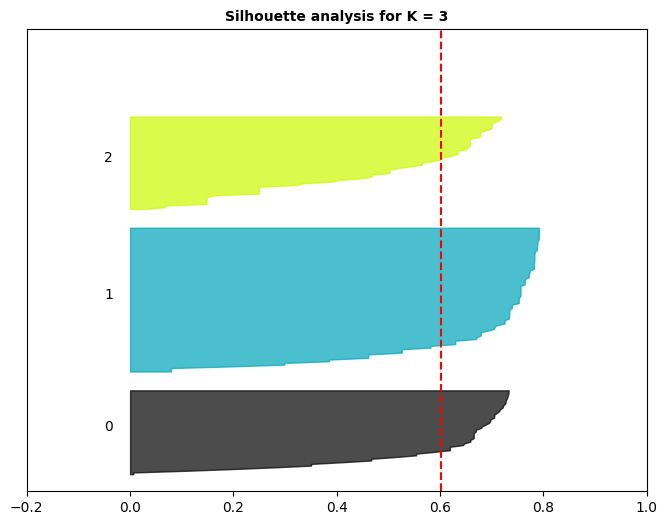

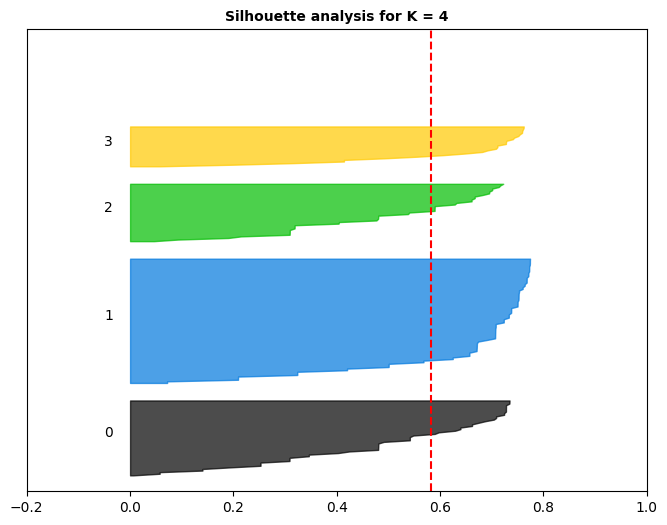

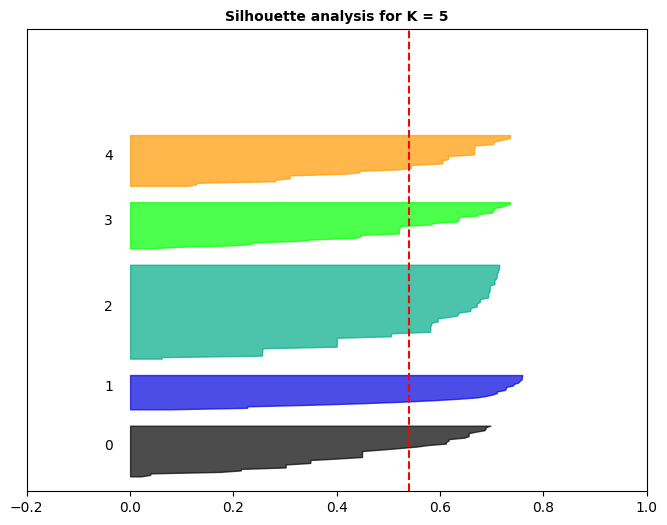

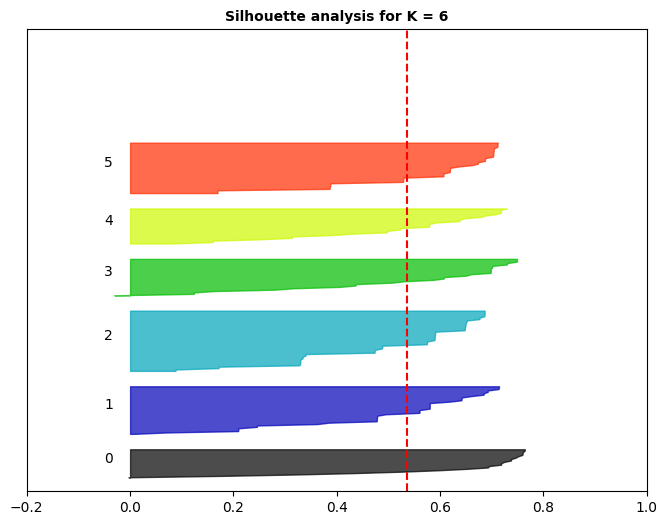

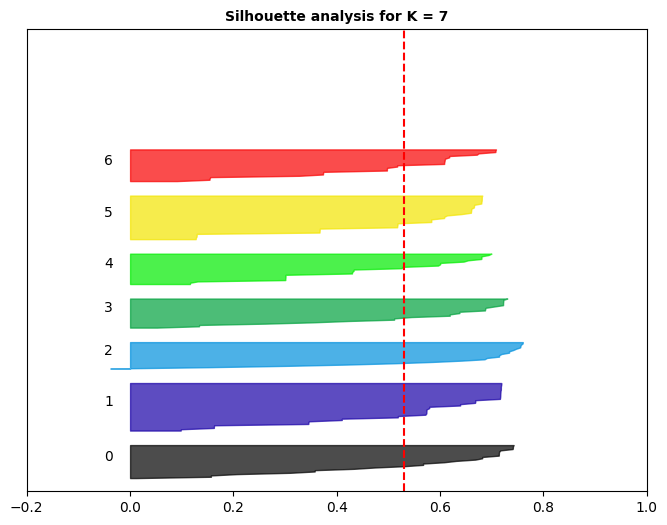

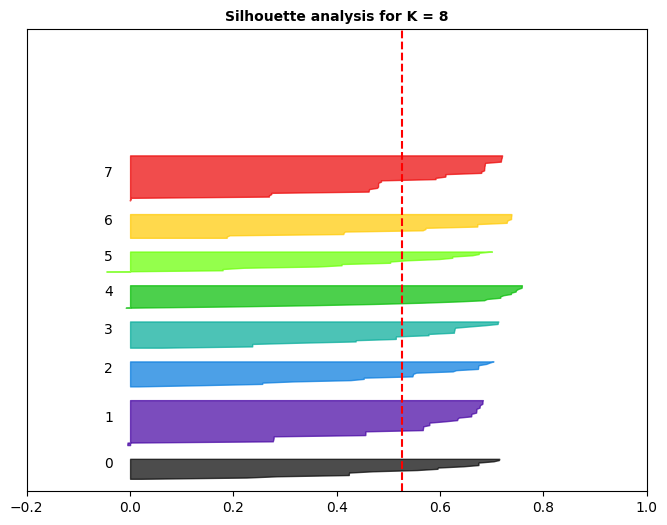

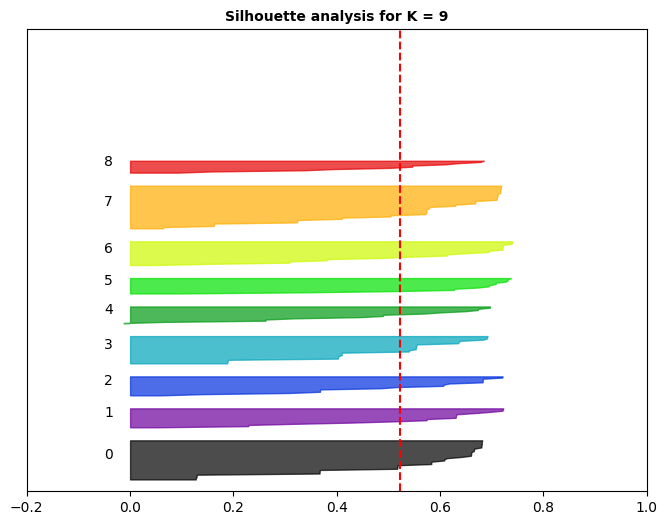

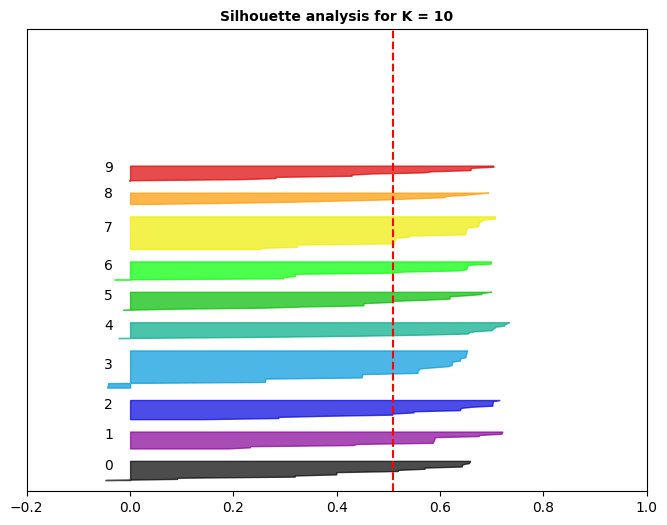

In [ ]:
n_clusters = np.argmax(scores) + 2  # Nombre optimal de clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(df4_array)
labels = kmeans.labels_
final_df['Cluster'] = labels

from sklearn.metrics                  import silhouette_samples, silhouette_score
import matplotlib.cm      as cm
# Running Kmeans
k = 10
kmeans_results = run_KMeans(k, final_df)

# Plotting Silhouette Analysis
silhouette(kmeans_results, final_df, plot=True)

Le score de silhouette offre une représentation plus riche que la courbe coudée.

Sur ce graphique, les barres verticales en rouge et en pointillé représentent le score de silhouette global pour chaque k choisi. On voit par exemple que pour tous les k représentés ici, le score de silhouette est trés  faible elle est entre 0,4 et 0,7, et varie peu. Ensuite, pour un k donné, on va avoir la représentation des scores de silhouette de chaque observation, regroupées par cluster. Par exemple, pour k = 10, ici, on voit bien dix couleurs différentes qui sont les 10 clusters modélisés. 

Les ordonnées sont toutes les observations clusterisées et en abscisses on a le score de silhouette de chaque observation. Si au sein d’un cluster, les observations ont un score de silhouette plus faible que le score de silhouette global (ligne verticale en rouge), cela signifie que les observations du clusters sont trop proches des autres clusters.


Enfin, quand le score de silhouette est négatif, cela signifie que la moyenne des distances de l’observation aux observations du cluster le plus proche est inférieure à la moyenne des distances de l’observation aux observations de son cluster. Cela signifie que l’observation est mal classée.

## Création des clusters

In [ ]:
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction == label)  # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis=0)  # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats]  # indices with top n_feats scores
        features = vectorizer.get_feature_names_out()
        best_features = [(features[i], x_means[i]) for i in sorted_means if i < len(features)]
        df = pd.DataFrame(best_features, columns=['features', 'score'])
        dfs.append(df)
    return dfs




def plotWords(dfs, n_feats):
    plt.figure(figsize=(8, 4))
    for i in range(0, len(dfs)):
        plt.title(("Most Common Words in Cluster {}".format(i)), fontsize=10, fontweight='bold')
        sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[i][:n_feats])
        plt.show()



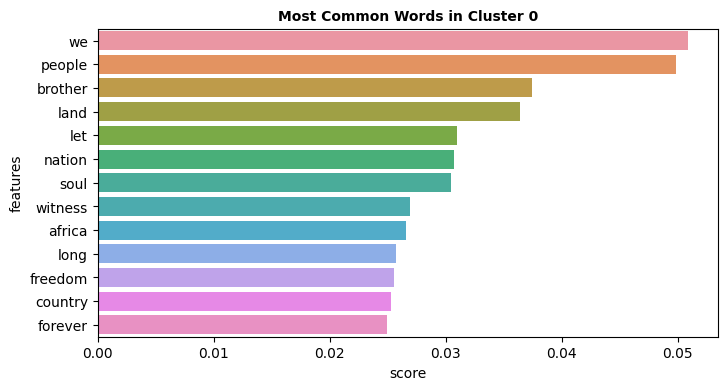

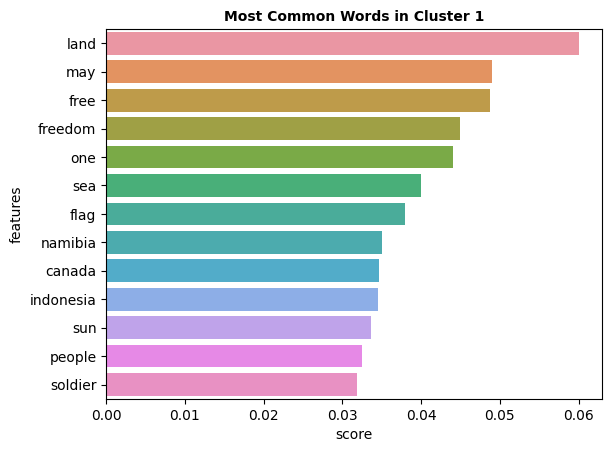

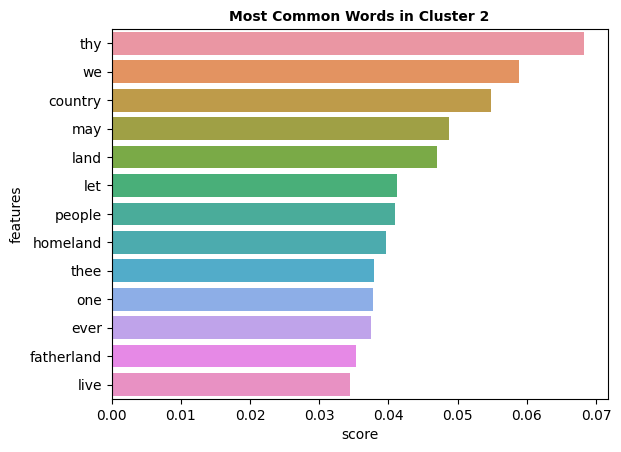

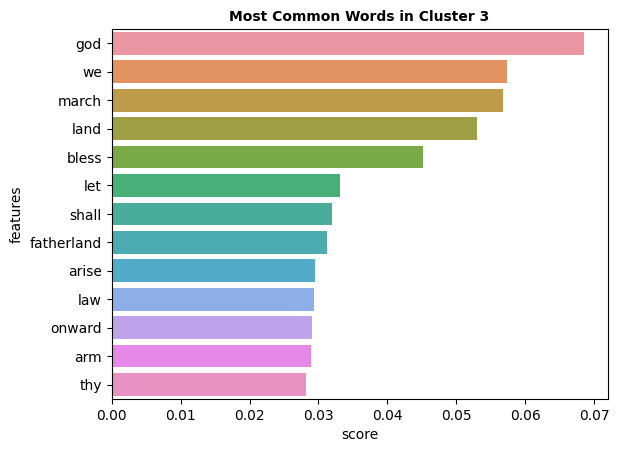

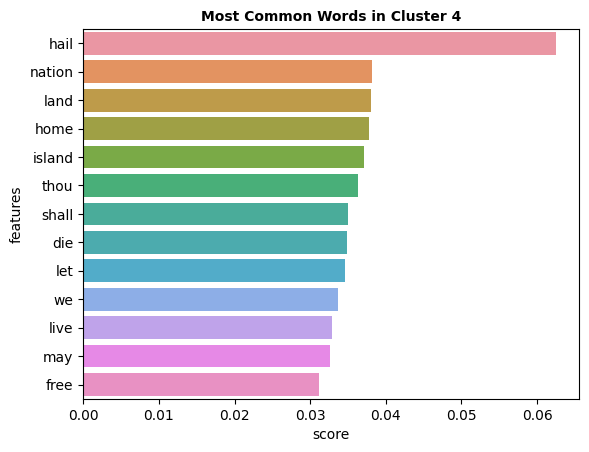

In [ ]:
best_result = 5
kmeans = kmeans_results.get(best_result)

final_df_array = final_df.to_numpy()

prediction = kmeans.predict(final_df)
n_feats = 20
dfs = get_top_features_cluster(final_df_array, prediction, n_feats)
plotWords(dfs, 13)

## Identification des mots significatifs dans chaque cluster

In [ ]:
final_df['Cluster'] = labels

for i in range(n_clusters):
    print(f"\nCluster {i}:")
    cluster_hymne = final_df[final_df['Cluster']==i]

    cluster_words = final_df.loc[final_df['Cluster']==i].drop(columns=['Cluster']).sum().sort_values(ascending=False)
    print(f"\nMots les plus fréquents par cluster {i}:")
    print(cluster_words[:10])


Cluster 0:

Mots les plus fréquents par cluster 0:
oh            0.614133
ethiopia      0.402014
song          0.389229
shall         0.366517
sudan         0.351028
foundation    0.325993
south         0.303816
national      0.302368
grace         0.292992
respect       0.270632
dtype: float64

Cluster 1:

Mots les plus fréquents par cluster 1:
beloved         0.354739
fatherland      0.314547
satisfaction    0.213825
decay           0.213825
madagascar      0.213825
bless           0.209698
thee            0.201142
create          0.198229
servant         0.198229
prosperous      0.187164
dtype: float64

Cluster 2:

Mots les plus fréquents par cluster 2:
mali         0.530589
africa       0.287385
let          0.201306
stand        0.177307
towards      0.175968
hard         0.154811
welcome      0.154811
happiness    0.148740
we           0.148110
common       0.141911
dtype: float64

Cluster 3:

Mots les plus fréquents par cluster 3:
fatherland    0.507915
war           0.409079
u

# Diminution des dimensions pour visualiser les clusters

In [ ]:
features = final_df.drop(columns=['Cluster']).values
features

In [ ]:
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features)

clusters = final_df['Cluster'].values

df_visualize = pd.DataFrame(data=features_pca, columns=['PC1', 'PC2'])
df_visualize['Cluster'] = clusters

In [ ]:
num_clusters = len(df_visualize['Cluster'].unique())

colors = cm.get_cmap('tab10', num_clusters)

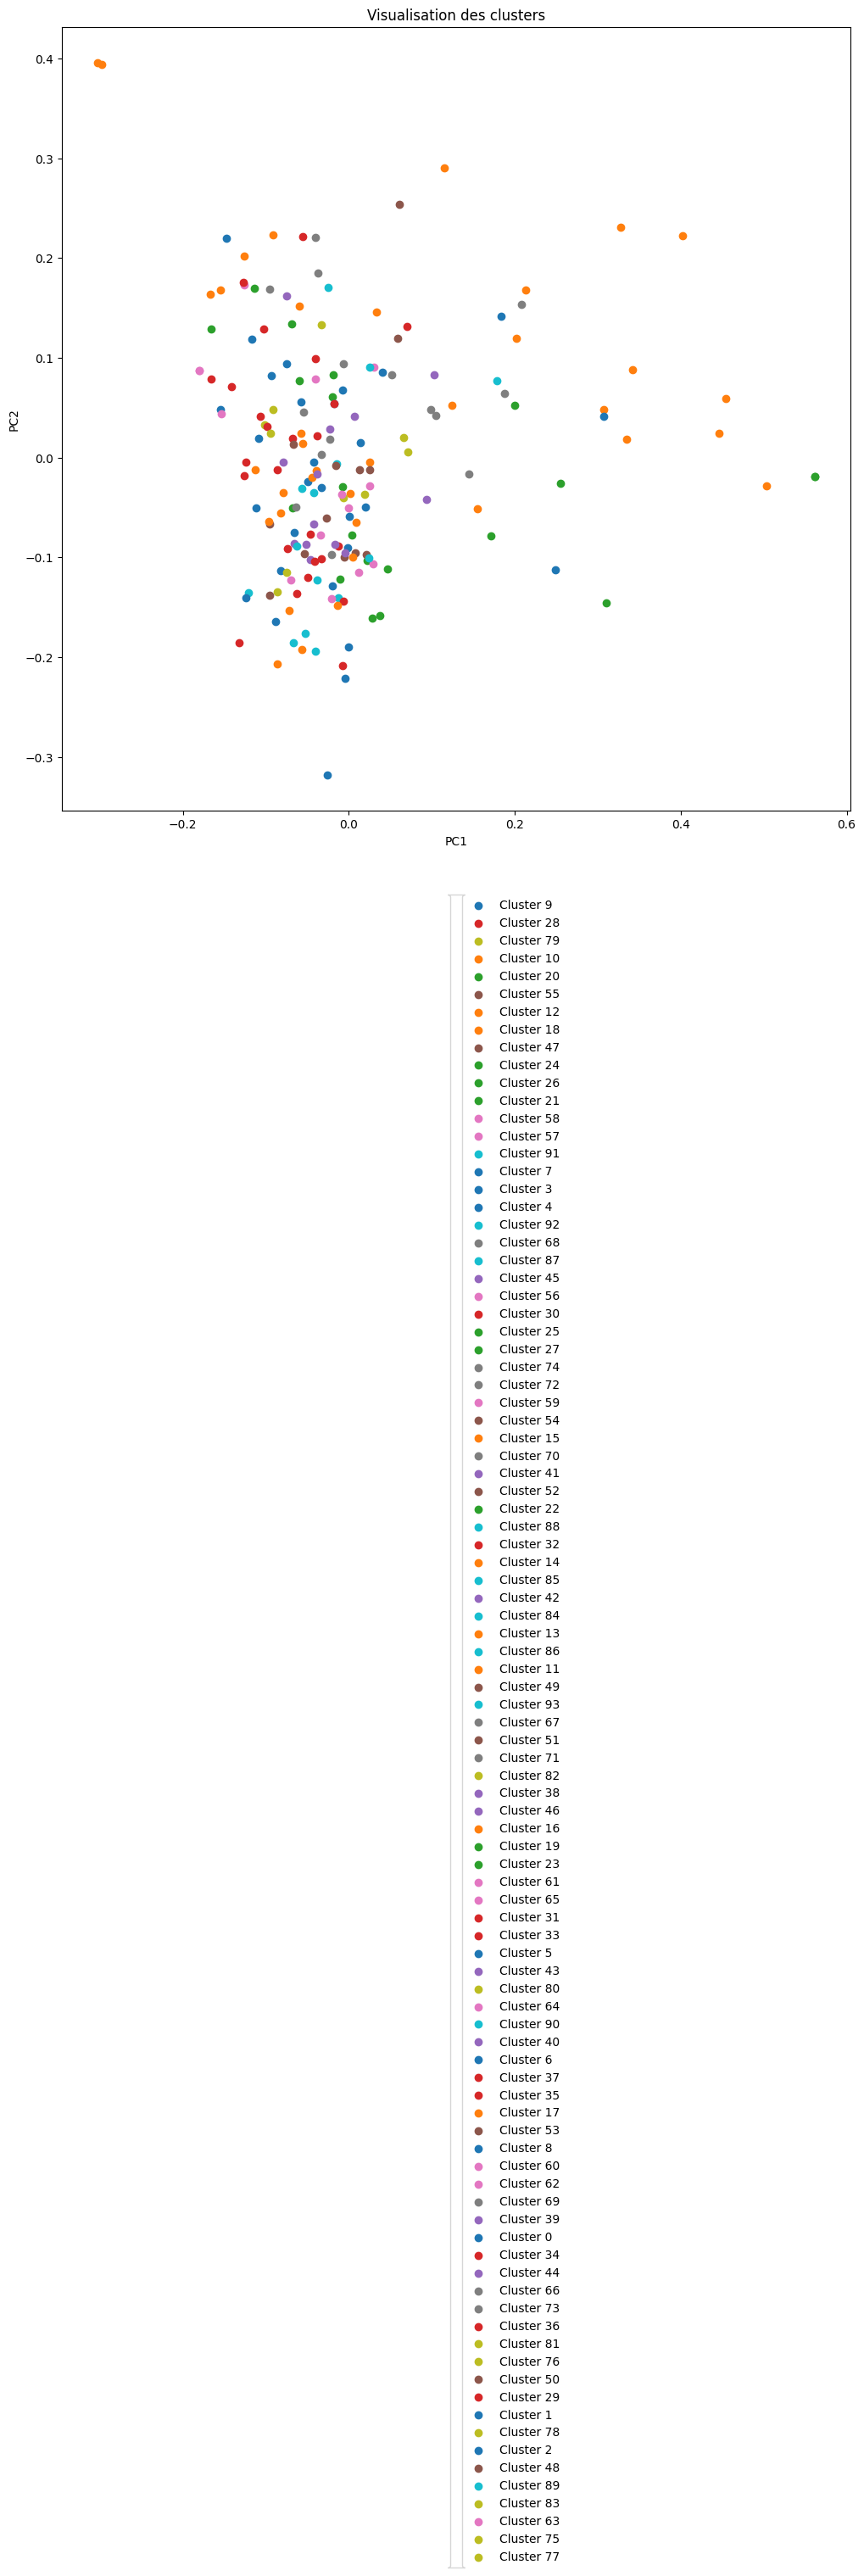

In [ ]:
plt.figure(figsize=(12, 12))

for cluster in df_visualize['Cluster'].unique():
    df_cluster = df_visualize[df_visualize['Cluster'] == cluster]
    plt.scatter(df_cluster['PC1'], df_cluster['PC2'], color=colors(cluster), label=f'Cluster {cluster}')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Visualisation des clusters')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=1, mode='expand')

plt.show()

In [ ]:
distance_matrix = pdist(df_visualize[['PC1', 'PC2']], metric='euclidean') #Matrice des distances de type euclidienne

In [ ]:
linkage_matrix = linkage(distance_matrix, method='average') #Regroupement hiérarchique
clusters = fcluster(linkage_matrix, t=10, criterion='maxclust') #définition du nombre de cluster dans chaque regroupement

In [ ]:
df_visualize['Merged_Cluster'] = clusters
color_map = plt.get_cmap('tab10')
merged_cluster_labels = df_visualize['Merged_Cluster'].unique()


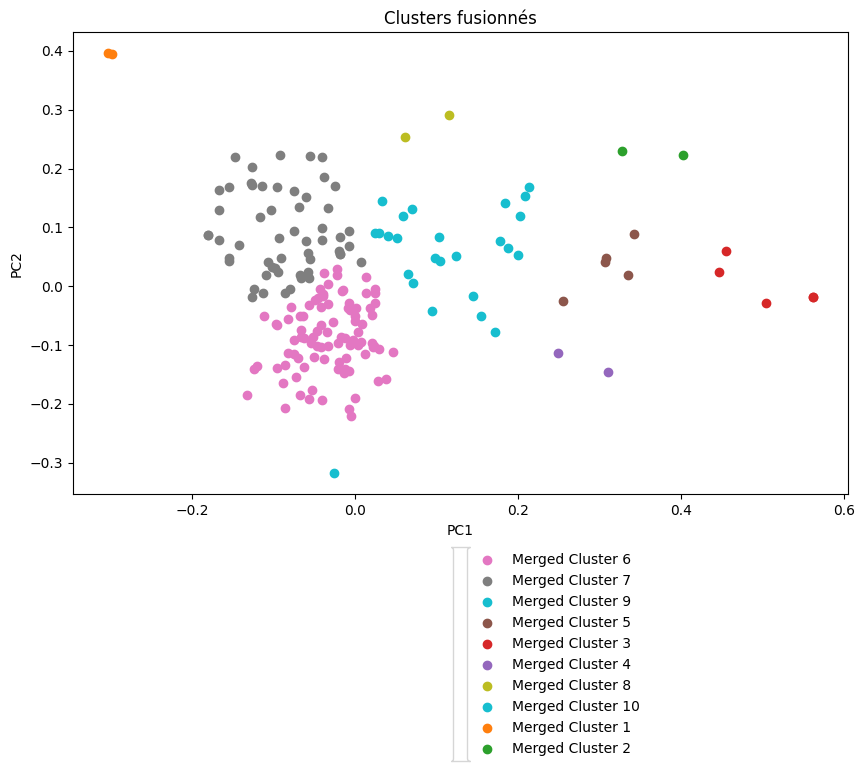

In [ ]:
plt.figure(figsize=(10,6))

for merged_cluster in merged_cluster_labels:
    df_merged_cluster = df_visualize[df_visualize['Merged_Cluster'] == merged_cluster]
    plt.scatter(df_merged_cluster['PC1'], df_merged_cluster['PC2'], color=color_map(merged_cluster), label=f'Merged Cluster {merged_cluster}')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Clusters fusionnés')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=1, mode='expand')

plt.show()

#Map of Words

Now that we can look at the graphs above and see the best scored words in each cluster, it's also interesting to make it prettier by making a map of words of each cluster!

In [ ]:
# Transforms a centroids dataframe into a dictionary to be used on a WordCloud.
def centroidsDict(centroids, index):
    a = centroids.T[index].sort_values(ascending = False).reset_index().values
    centroid_dict = dict()

    for i in range(0, len(a)):
        centroid_dict.update( {a[i,0] : a[i,1]} )

    return centroid_dict

def generateWordClouds(centroids):
    wordcloud = WordCloud(max_font_size=100, background_color = 'white')
    for i in range(0, len(centroids)):
        centroid_dict = centroidsDict(centroids, i)        
        wordcloud.generate_from_frequencies(centroid_dict)

        plt.figure()
        plt.title('Cluster {}'.format(i))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()

In [ ]:
final_df

In [ ]:
from wordcloud    import WordCloud

# Supprimer la colonne "Cluster" de final_df
final_df_without_cluster = final_df.drop("Cluster", axis=1)

# Créer le DataFrame centroids à partir des centroïdes
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=final_df_without_cluster.columns)

# Générer les nuages de mots
generateWordClouds(centroids)


In [ ]:
# Assigning the cluster labels to each country
labels = kmeans.labels_ 
df0['label'] = labels
df0.head()

,Country,Alpha-2,Alpha-3,Continent,Anthem,label
0,Albania,AL,ALB,Europe,"Around our flag we stand united, With one wish...",9
1,Armenia,AM,ARM,Europe,"Our Fatherland, free, independent, That has fo...",28
2,Austria,AT,AUT,Europe,"Land of mountains, land by the river, Land of ...",79
3,Azerbaijan,AZ,AZE,Europe,"Azerbaijan, Azerbaijan! The glorious Fatherlan...",10
4,Belarus,BY,BLR,Europe,"We, Belarusians, are peaceful people, Wholehea...",20


In [ ]:
pip install geopandas

In [ ]:
# Map Viz
import json
import geopandas as gpd
import json
# Loading countries polygons
geo_path = '/content/world-countries.json'
country_geo = json.load(open(geo_path))
gpf = gpd.read_file(geo_path)

# Merging on the alpha-3 country codes
merge = pd.merge(gpf, df0, left_on='id', right_on='Alpha-3')
data_to_plot = merge[["id", "name", "label", "geometry"]]

data_to_plot

In [ ]:
import branca.colormap as cm

# Creating a discrete color map
values = data_to_plot[['label']].to_numpy()
color_step = cm.StepColormap(['r', 'y','g','b', 'm'], vmin=values.min(), vmax=values.max(), caption='step')
color_step

In [ ]:
import folium
from branca.element import Figure

def make_geojson_choropleth(display, data, colors):
    '''creates geojson choropleth map using a colormap, with tooltip for country names and groups'''
    group_dict = data.set_index('id')['label'] # Dictionary of Countries IDs and Clusters
    tooltip = folium.features.GeoJsonTooltip(["name", "label"], aliases=display, labels=True)
    return folium.GeoJson(data[["id", "name","label","geometry"]],
                          style_function = lambda feature: {
                               'fillColor': colors(group_dict[feature['properties']['id']]),
                               #'fillColor': test(feature),
                               'color':'black',
                               'weight':0.5
                               },
                          highlight_function = lambda x: {'weight':2, 'color':'black'},
                          smooth_factor=2.0,
                          tooltip = tooltip)

# Makes map appear inline on notebook
def display(m, width, height):
    """Takes a folium instance and embed HTML."""
    fig = Figure(width=width, height=height)
    fig.add_child(m)
    return fig

In [ ]:
# Initializing our Folium Map
m = folium.Map(location=[43.5775, -10.106111], zoom_start=2.3, tiles='cartodbpositron')

# Making a choropleth map with geojson
geojson_choropleth = make_geojson_choropleth(["Country:", "Cluster:"], data_to_plot, color_step)
geojson_choropleth.add_to(m)

width, height = 1300, 675
display(m, width, height)
m

In [ ]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

# Effectuer le partitionnement hiérarchique
Z = linkage(final_df, method='average', metric='euclidean')

# Tracer le dendrogramme
plt.figure(figsize=(10, 6))
plt.title("Dendrogramme")
plt.xlabel("Indices des échantillons")
plt.ylabel("Distance")
dendrogram(Z, leaf_rotation=90., leaf_font_size=8.)
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

# Perform hierarchical clustering

Z = linkage(final_df, 'ward')
# Set the threshold to obtain clusters
threshold = 1.0
clusters = fcluster(Z, threshold, criterion='distance')

# Compute TF-IDF matrix
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(final_df)

# Get top features (words) for each cluster
def get_top_features_cluster(tfidf_matrix, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction == label)
        x_means = np.mean(tfidf_matrix[id_temp], axis=0).A1
        sorted_means = np.argsort(x_means)[::-1][:n_feats]
        features = vectorizer.get_feature_names_out()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns=['features', 'score'])
        dfs.append(df)
    return dfs

# Generate dendrogram
plt.figure(figsize=(10, 6))
dendrogram(Z, leaf_rotation=90., leaf_font_size=2.)
plt.title("Dendrogram")
plt.xlabel("Indices des échantillons")
plt.ylabel("Distance")
plt.show()

# Select the clusters to display
selected_clusters = [0, 2, 4]  # Adjust the cluster indices as per your requirement

# Get top features for selected clusters
n_feats = 10
dfs = get_top_features_cluster(tfidf_matrix, clusters, n_feats)

# Plot most frequent words in selected clusters
plt.figure(figsize=(8, 4))
for i in selected_clusters:
    plt.title("Most Common Words in Cluster {}".format(i))
    sns.barplot(x='score', y='features', orient='h', data=dfs[i])
    plt.show()


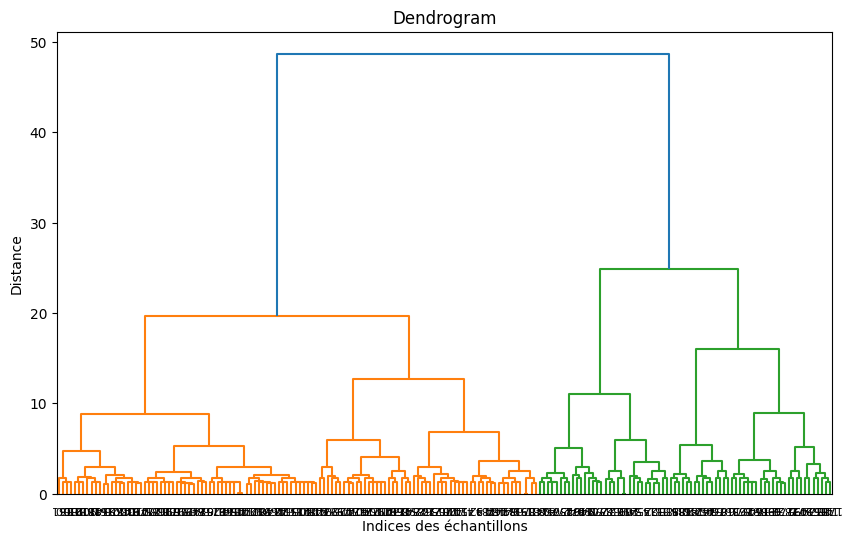

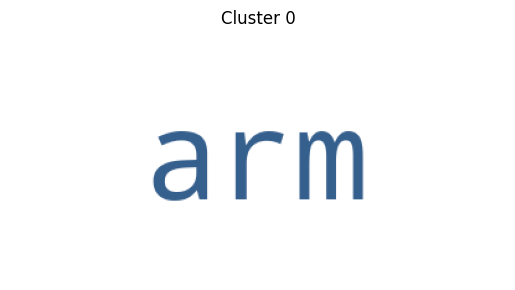

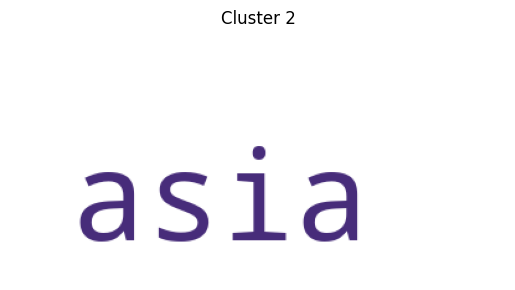

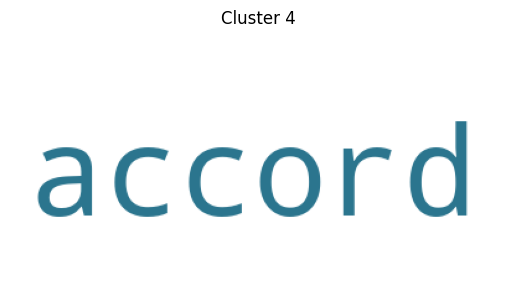

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from wordcloud import WordCloud

# Perform hierarchical clustering
Z = linkage(final_df, method='average', metric='euclidean')

# Set the threshold to obtain clusters
threshold = 1.0
clusters = fcluster(Z, threshold, criterion='distance')

# Compute TF-IDF matrix
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(final_df)

# Get top features (words) for each cluster
def get_top_features_cluster(tfidf_matrix, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction == label)
        x_means = np.mean(tfidf_matrix[id_temp], axis=0).A1
        sorted_means = np.argsort(x_means)[::-1][:n_feats]
        features = vectorizer.get_feature_names_out()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns=['features', 'score'])
        dfs.append(df)
    return dfs

# Generate dendrogram
plt.figure(figsize=(10, 6))
dendrogram(Z, leaf_rotation=900., leaf_font_size=8.)
plt.title("Dendrogram")
plt.xlabel("Indices des échantillons")
plt.ylabel("Distance")
plt.show()

# Select the clusters to display
selected_clusters = [0, 2, 4]  # Adjust the cluster indices as per your requirement

# Get top features for selected clusters
n_feats = 10
dfs = get_top_features_cluster(tfidf_matrix, clusters, n_feats)

# Generate word clouds for selected clusters
for i in selected_clusters:
    centroid_dict = dict(zip(dfs[i]['features'], dfs[i]['score']))
    wordcloud = WordCloud(max_font_size=100, background_color='white')
    wordcloud.generate_from_frequencies(centroid_dict)
    
    plt.figure()
    plt.title('Cluster {}'.format(i))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
